## Notes on Workflow

**Aims/Objective:** Assess how "sensitive" your autoencoder is to its initialization and get a sense of how stable the learned embeddings are across different training runs. This approach is especially valuable in research or in situations where reproducibility and stability of the model are crucial.

<br>

<br>

**Recall in each realization, we do the following:**

1. Train an autoencoder, and then applying k-means to the latent space to identify clusters.
2. These clusters are then matched to the true labels to minimize the discrepancies between predicted and true cluster assignments.
3. After matching, for each data point, if the matched predicted cluster is different from its true label, it's considered a "change", and the corresponding entry in `cluster_changes` is incremented.

When clustering in latent space the following steps are followed:

1. **Initialization**:
    - `cluster_changes` is initialized as a zero array with the same shape as the `target` (truth labels). This means initially, all data points have 0 changes.
    - `predicted_clusters` is computed for each realization after clustering in the latent space.
    - The percentage change computation  function is a sequential comparison and not comprehensive across all AE realization pairs, if you want a global stability/instability view, then consider the Jaccard similarity instead.The sequential change in percentages is useful for understanding the immediate stability of the model from one realization to the next.
    - It can highlight how sensitive the model is to small changes in the random seed or initialization parameters. On the other hand, the Jaccard similarity across all pairs of realizations offers a broader view of overall stability and consistency across the entire range of realizations.<br>


2. **Matching clusters with truth labels**:
    - A cost matrix is computed to find the best correspondence between predicted clusters and the true labels.
    - The Hungarian algorithm (`linear_sum_assignment`) is used to determine the optimal assignment.
    - After the best assignment is determined, `predicted_clusters` labels are rearranged to match the true labels as closely as possible.<br>


3. **Tracking changes**:
    - For each data point, if its assigned cluster (`predicted_clusters`) doesn't match its true label (`target`), its corresponding value in `cluster_changes` is incremented by 1.
    - This process is repeated for all realizations.

    - The `cluster_changes` array accumulates these "changes" for each data point over all realizations. After all realizations are done, the value for a data point in `cluster_changes` represents how many times (out of all realizations) the predicted cluster for that data point didn't match its true label. This becomes a tell-tale sign of stability in the latent feature space.

    - The introduction of stochastic uncertainty through changing the random seed is a way to account for and analyze the variability in model training and performance. By training a model multiple times with different seeds, you can assess the robustness of the model and gain insights into how sensitive it is to variations in initialization and training data presentation. It helps in understanding the model's generalization and can be useful for hyperparameter tuning and model evaluation.<br>


4. **Index Tracking across realizations (apples to apples comparisons):**
    - The CustomDataset class returns both the data and its index, but when shuffled in the DataLoader, the indices will follow the same shuffling order as the data. During training, you get both data and indices from the DataLoader to ensure no bias in the training.
    - Hence, the indices are not used in training and are only needed for evaluation. When evaluating, you need to reorder the embeddings according to the original indices in the CustomDataset.
    - This is done by first getting the embeddings and their original indices, and then using np.argsort to reorder the embeddings to match the original data order. This approach ensures that despite shuffling during training, you can align the embeddings from different autoencoders to their corresponding original data points. This alignment is crucial for comparing embeddings across different training runs with different seeds and is performed for each realization.<br>


5. **Limitations of global anisotropy:**

    - In datasets with multiple clusters, anisotropy might not accurately reflect the separation or relative positioning of these clusters. It may only indicate the overall spread without detailing/capturing the intra-cluster and inter-cluster variations/spread. Hence, regions of high data point concentration versus sparse regions may not be properly differentiated. Hence, the introduction of local anisotropy calculations, that covers this limitations by using the harmonic average of such examples as a more robust anisotropic measure.<br>


6. **Understanding the use of convex hulls in workflow:**
Idea of using the convex hull vertices to study the variability of inferences in different autoencoder realizations is quite innovative and can be a valuable approach. Here's why this could be beneficial and how you might go about it:

    *Advantages of Using Convex Hull Vertices:*
    1. Stability Analysis: By examining how the vertices of the convex hull change with different random seeds, you can assess the stability and robustness of the autoencoder. Consistent vertices across different realizations suggest that the autoencoder is reliably capturing the same underlying structure in the data.
    2. Identifying Anchor Points: Convex hull vertices can serve as "anchor points" in your latent space, providing a way to understand the extremities or boundaries of the representations learned by the autoencoder.
    3. Quantitative Analysis: Changes in the vertices can be quantified, allowing for a more systematic analysis of variability. Metrics like the distance between corresponding vertices in different realizations, or the area/volume of the convex hulls, can provide insights into the variability induced by different seeds.

    *Implementing the Analysis:*
    1. Compute Convex Hull: For each autoencoder realization, use the encoded latent space representations to compute the convex hull. Tools like scipy.spatial.ConvexHull in Python can be useful for this.
    2. Compare Vertices: Analyze how the vertices of these convex hulls vary across different realizations. You might consider:
        * The position of vertices.
        * The number of vertices.
        * Geometric properties like the area or volume enclosed by the convex hull.
    3. Statistical Analysis: Perform statistical tests or visualizations to understand the degree of variability. For instance, plotting the convex hulls from different realizations can visually show the differences.
    4. Correlation with Seeds: Investigate if there's any pattern or correlation between the changes in the convex hull and the random seeds used. This might reveal how sensitive the autoencoder's latent space is to initialization.

    *Considerations:*
    1. Dimensionality: If your latent space is high-dimensional, the interpretation of convex hulls can become complex. Consider dimensionality reduction techniques for visualization and analysis.
    2. Comparability: Ensure that the method used for comparing vertices is consistent and meaningful across different realizations.

    In summary, using the convex hull vertices to analyze the impact of different random seeds on the latent space of an autoencoder is a promising approach. It can provide insights into the stability and variability of the autoencoder's learned representations, aiding in the understanding of how different initializations affect the model's inferences.<br>


7. **Advantages of Minibatch Training for Small Datasets:**

    1. Regularization: Minibatch training introduces noise into the training process, which can act as a form of regularization. This can help prevent overfitting, even on small datasets.
    2. Efficiency: Minibatch training allows you to take advantage of parallelism, such as using GPUs, which can significantly speed up training even for small datasets.
    3. Convergence: Minibatch training can lead to faster convergence, which means your model reaches a good solution more quickly.
    4. Memory Efficiency: Training on the full dataset might not fit into memory, especially when the dataset is very large. Minibatch training allows you to work with smaller portions of the data at a time.

    *Considerations for Minibatch Training on Small Datasets:*

    1. Batch Size: When working with a small dataset, you should carefully choose the batch size. Very small batch sizes can introduce high variance in gradient updates, while very large batch sizes may not provide the regularization benefits of minibatch training. You may need to experiment to find the optimal batch size for your specific dataset and model.
    2. Learning Rate: Smaller batch sizes may require smaller learning rates to prevent overshooting during optimization. Again, hyperparameter tuning may be necessary.
    3. Validation Set: With a small dataset, it's crucial to have a validation set to monitor model performance. Overfitting can still occur, especially if your model has many parameters.
    4. Data Augmentation: Data augmentation techniques (e.g., flipping, rotating, cropping) can help artificially increase the effective size of your dataset, making minibatch training more effective.
    5. Transfer Learning: If your small dataset is similar to a larger dataset, you can consider using pre-trained models and fine-tuning them on your dataset.
    6. In summary, while minibatch training can be beneficial for small datasets, it requires careful consideration of batch size, learning rate, and other hyperparameters. Additionally, techniques like data augmentation and transfer learning can be used to make the most of small datasets. Ultimately, the choice of whether to use minibatch training or not depends on the specific problem and constraints you are dealing with.<br>


8. **Moran's statistic:** We use a one tailed Moran as a measure of overall spatial autocorrelation where -1: perfect clustering of dissimilar values/objects (perfect dispersion), 0: perfect randomness, 1: perfect clustering of similar values/objects.<br>

9.

## Notes on Jaccard Similarity Computation on Anchors

The choice of Jaccard similarity for analyzing the vertices of convex hulls across different realizations of an autoencoder is primarily due to its suitability for comparing sets, especially when the elements of these sets are categorical or discrete, like indices in this case. Here are some key reasons why Jaccard similarity is a good fit for this analysis:

1. **Measuring Overlap in Sets:** Jaccard similarity is specifically designed to measure the similarity between finite sets. It's calculated as the size of the intersection divided by the size of the union of the sets. In the context of convex hull vertices, it quantifies how many vertices are common between any two realizations relative to the total unique vertices in both.

2. **Applicability to Your Analysis:** In your scenario, you're comparing sets of indices (vertices of convex hulls). Jaccard similarity directly addresses this by evaluating how similar these sets are across different realizations, providing a clear and interpretable metric for the stability of your model's latent space representations.

3. **Robustness to Size Variations:** The Jaccard index is robust to variations in the size of the sets. It's particularly useful when the number of vertices in the convex hulls might change across realizations, as it normalizes the similarity by the union of the sets.

4. **Intuitive and Interpretable:** The Jaccard similarity yields a value between 0 and 1, where 1 indicates identical sets and 0 indicates no common elements. This makes it easy to interpret in terms of similarity or dissimilarity.

5. **Widely Used in Comparative Analysis:** Jaccard similarity is a well-established metric in various fields including biology (for species similarity), text analysis (similarity of documents), and machine learning (comparing clusters or sets), making it a reliable choice.

Given these properties, Jaccard similarity provides a straightforward and effective way to compare the convex hull vertices across different model realizations and to gauge the stability and consistency of the model's inferences.


Jaccard Similarity of 1: A Jaccard similarity score of 1 means that the sets of vertices (convex hulls) being compared are exactly the same. This would mean that two realizations of the autoencoder have produced identical sets of vertices for their convex hulls. This indicates total stability, as the model's latent space representation is consistent across these AE realizations.

Jaccard Similarity of 0: Conversely, a Jaccard similarity score of 0 means that there is no overlap between the sets; they are completely different. For my application, this implies total instability, as the sets of vertices (anchor points in the latent space) for the convex hulls in these two realizations do not match at all.
Therefore, in terms of evaluating the stability of the model's latent space representations across different AE realizations:

High Jaccard scores (close to 1) across most pairs of realizations suggest a high degree of stability. (Hence the use of neffective to determine how many AE realizations is needed to attain stability in the latent space for inference making)

Lower Jaccard scores (especially those close to 0) indicate more variability or instability in how the model is representing the data under different initializations.

The Jaccard similarity calculation in your code is inherently independent of the sorting order of the individual convex hull vertex arrays. The Jaccard similarity is a measure of the similarity between two sets, and it's calculated as the size of the intersection divided by the size of the union of the sets.

Here's why the sorting of the convex_hull_vertices doesn't impact the Jaccard similarity:

Set Conversion: When you convert vertices_i and vertices_j into sets (set_i and set_j), the order of elements is disregarded. A set in Python is an unordered collection of items where each element is unique (no duplicates).
Intersection and Union Operations: The operations for calculating the intersection (set_i.intersection(set_j)) and union (set_i.union(set_j)) of sets are also independent of the original order of elements in those sets. They merely check for the presence or absence of elements.
Jaccard Similarity Formula: The Jaccard similarity is calculated based on the number of elements in the intersection and union of the sets. Since these are set operations, they are not affected by the order of elements in the original arrays.
Therefore, whether the arrays in convex_hull_vertices are sorted or not will not change the outcome of your Jaccard similarity calculations. The similarity is purely based on the content (i.e., the presence or absence of certain elements) of the sets, not on their order.

The Jaccard similarity calculation is indeed independent of the order of elements in the sets being compared. This is because the Jaccard similarity index is a measure of the similarity between two sets, and is calculated based solely on the elements contained in these sets, not on the order in which these elements appear.

In [1]:
# import pandas as pd
# import numpy as np
# import numpy.linalg as la
# import random
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# import matplotlib.lines as mlines
# from matplotlib.patches import Ellipse
# import matplotlib.gridspec as gridspec
# import seaborn as sns
# import scipy.stats
# import scipy.linalg as linalg
# from scipy.stats import gaussian_kde
# from scipy.spatial.distance import squareform, pdist
# from scipy.stats import spearmanr, pearsonr, entropy
# from fastcluster import linkage
# from sklearn.preprocessing import StandardScaler
# from skimage import measure
# import torch
# import torch.linalg


# Load Packages
from Functions import *
# from sklearn.datasets import load_wine
import time
import pickle
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
import libpysal
from esda.moran import Moran
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
from itertools import combinations

# Set plot default
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams["axes.grid"] = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Template to load synthetic dataset
df = pd.read_csv("High_Dim_Dataset_with_Target_rho_1.csv")
target = df.iloc[:,-1].values # response
df_scaled = df.iloc[:, :4].values # predictors

# Template to load wine dataset


In [3]:
# Instantiate dataset customization class
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], idx

In [4]:
# Instantiate AE class
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
# Set Parameters for AE and format dataset to tensor via pytorch
dataset = CustomDataset(torch.tensor(df_scaled, dtype=torch.float32))
num_epochs = 10 #10000
batch_size = 16
lr=0.001
input_dim = df_scaled.shape[1]
encoding_dim = 2
model = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

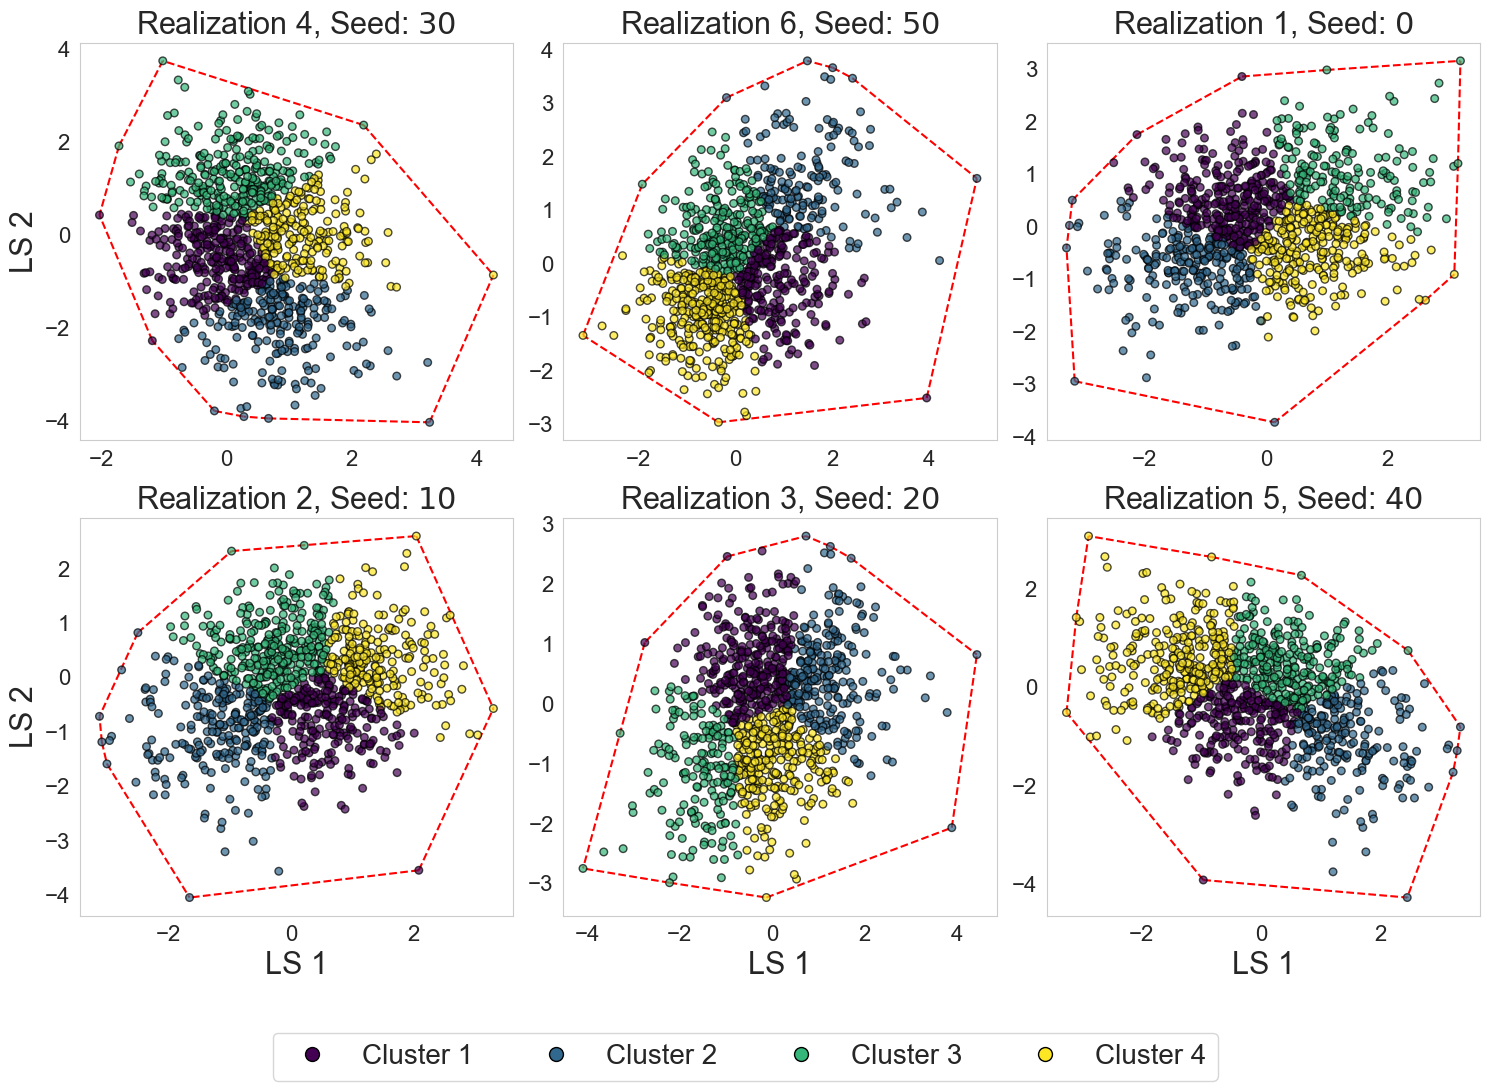

Total execution time: 56.41247797012329 seconds


In [6]:
# Time Tracker
start_time = time.time()

## Experiment Settings
# Random State/Seed Parameter Settings
num_seeds = num_realizations = 6 #1000
initial_seed = 0 # starting sequence for random seed generator
random.seed(initial_seed) # Initialize starting seed to ensure random seed sequence reproducibility
step_size = 10   # Change this to increase seeds every 'x' units as needed
seed_values = [initial_seed + (step_size * i) for i in range(num_seeds)] # sequence for selecting seeds used

# Variable Initialization to Store Results
cluster_changes = np.zeros_like(target)  # To track changes in cluster assignments
n_clusters = len(np.unique(target))  # nos of clusters in target if classification/ clustering problem
change_percentages = []  # List to store percentage of changed clusters for each realization
statistics_array = np.empty((num_seeds, 4)) # Array to store instability measures
convex_hull_vertices = [] # List to store convex hull vertices index for each realization
all_loss_curves = [] # MSE loss curves for each AE realizations
local_anisotropies = [] # List to store density dependent local anisotropies found within data
hdf5_file = 'embedding_realizations.h5' # store each latent space for all AE realizations here
with h5py.File(hdf5_file, 'w') as f: # Make the HDF5 file to store each AE realization latent space
    pass

# Make 3x3 subplot for 6 randomly selected AE realizations latent space visualizations
n_rows = 2
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axs = axs.ravel()
random.seed(initial_seed)
visualization_indices = random.sample(range(num_seeds), 6)

#   Fix ticks params in entire sublot
for ax in axs:
    ax.tick_params(axis='both', labelsize=16)

# Adding Y-axis labels to the first column
for ax in range(n_rows):
    axs[ax * n_cols].set_ylabel("LS 2", fontsize=22)

# Adding X-axis label to the bottom row
for ax in axs[n_cols:]:
    ax.set_xlabel("LS 1", fontsize=22)

# Run experiment
for idx, seed in enumerate(seed_values):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    #reset_environment(seed=seed)
    generator = torch.Generator().manual_seed(seed)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=generator)

    model = Autoencoder(input_dim, encoding_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    epoch_losses = []
    for epoch in range(num_epochs):
        total_loss = 0
        for data, indices in dataloader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        epoch_losses.append(total_loss / len(dataloader))
    all_loss_curves.append(epoch_losses)

    # Reorder the embeddings gotten based on the originlal data index
    with torch.no_grad():
        encoded_data, original_indices = zip(*[(model.encoder(d[None, ...]), idx) for d, idx in dataset])
        # Reordering step here
        encoded_data = torch.cat(encoded_data, dim=0).numpy()
        order = np.argsort(original_indices)
        encoded_data = encoded_data[order]

        # Save each latent space embeddings to an HDF5 file
        with h5py.File(hdf5_file, 'a') as f:
            f.create_dataset(f'embedding_realizations_{idx}', data=encoded_data)

    # Perform clustering based on the number of clusters present in the response feature
    kmeans = KMeans(n_clusters=n_clusters, n_init=10).fit(encoded_data)
    predicted_clusters = kmeans.labels_

    # Matching predicted clusters to true clusters
    cost_matrix = -np.array([[np.sum((predicted_clusters[true_indices] == pred_cluster))
                              for pred_cluster in range(n_clusters)]
                             for true_indices in [np.where(target == i)[0] for i in range(n_clusters)]])
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    for i in range(n_clusters):
        predicted_clusters[predicted_clusters == col_ind[i]] = -(i+10)  # Temporarily set to negative values
    for i in range(n_clusters):
        predicted_clusters[predicted_clusters == -(i+10)] = i

    changes = (predicted_clusters != target)
    change_percentages.append(100 * np.sum(changes) / len(target))
    cluster_changes += changes

    ## Compute statistics for each of the latent spaces for each AE realizations
    # Spatial
    weights = libpysal.weights.lat2W(encoded_data.shape[0],encoded_data.shape[1], rook=False, id_type="float")
    mi = Moran(encoded_data, weights)
    moran = mi.I

    # Anisotropy calcs
    mvee_anis= run_mvee(array_2d=encoded_data, plotter=False)
    global_anis, _, _ = compute_anisotropy(array_2d=encoded_data, type='global', plotter=False)
    _, local_anis, harmonic_anis = compute_anisotropy(array_2d=encoded_data, type='local', plotter=False)

    # Compute convex hull and associated attributes
    my_points = encoded_data.copy()
    hull = ConvexHull(my_points)
    vertices_idx = hull.vertices
    vertices = my_points[hull.vertices]
    polygon = Polygon(vertices)

    # Store the computed statistics
    statistics_array[idx, :] = [moran, mvee_anis, global_anis, harmonic_anis]
    local_anisotropies.append(np.array(local_anis))
    convex_hull_vertices.append(vertices_idx)

    # Check if the current realization index is in the list of visualization_indices
    if idx in visualization_indices:
        # Visualization of latent space in 3x3 grid
        scatter = axs[visualization_indices.index(idx)].scatter(encoded_data[:, 0], encoded_data[:, 1], c=predicted_clusters, cmap='viridis', marker='o', s=30,
                      alpha=0.7, edgecolor='black', zorder=2)
        axs[visualization_indices.index(idx)].set_title(f"Realization {idx + 1}, Seed: ${seed}$", fontsize=22)

        for simplex in hull.simplices:
            axs[visualization_indices.index(idx)].plot(my_points[simplex, 0], my_points[simplex, 1], 'r--', zorder=1)

        # Create colorbar based on the nos of clusters in target variable i.e., response feature
        n_clusters = len(np.unique(target))
        viridis = ListedColormap(plt.cm.viridis(np.linspace(0, 1, n_clusters)))

        # Create Line2D object for the legend
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {i+1}',
                                  markersize=10, markerfacecolor=viridis.colors[i], markeredgewidth=1, markeredgecolor='black') for i in range(n_clusters)]

# Save statistics to numpy files
np.save('statistics_array.npy', statistics_array)

fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.10), ncol=n_clusters, fontsize=20)
plt.tight_layout()
plt.savefig('LS Visualization for Select AE Realizations with Convex Hull Line.tiff', dpi=300, bbox_inches='tight')
plt.show(block=False)

end_time = time.time()
total_time = end_time - start_time
print(f"Total execution time: {total_time} seconds")

Visualize training loss for select AE realizations

The minimum loss for all AE realizations is:  0.09312


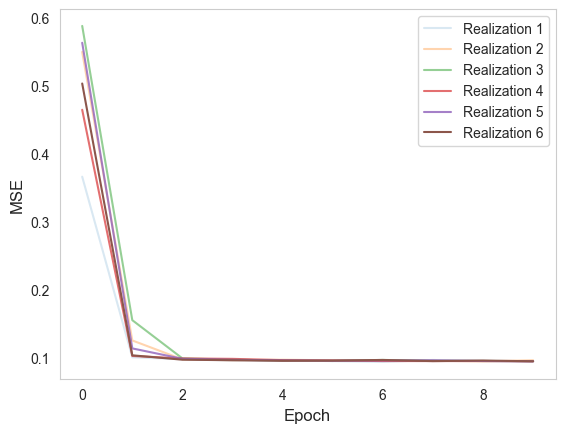

In [7]:
## Training Loss for Select AE Realizations over 10000 Epochs
loss_val = round(np.min(all_loss_curves),5)
print('The minimum loss for all AE realizations is: ',loss_val)

# Generate alpha values within the range [0, 1]
alphas = [i/num_seeds for i in range(1, num_seeds + 1)]

# Visualize loss functions for select realizations
for idx, losses in enumerate(all_loss_curves):
    if idx in visualization_indices:
        plt.plot(losses, label=f'Realization {idx+1}', alpha=alphas[idx])

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.legend()
plt.savefig('Training loss for select realizations.tiff', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Compute the percentage changes in anchors found via convex hull
change_anchors = percentage_change(convex_hull_vertices, data_type='list')

# Compute the percentage changes in Moran's
change_moran = percentage_change(statistics_array[:,0], data_type='numpy')

# Compute the percentage changes in anisotropies found
change_mvee_anis = percentage_change(statistics_array[:,1], data_type='numpy')
change_global_anis = percentage_change(statistics_array[:,2], data_type='numpy')
change_har_anis = percentage_change(statistics_array[:,3], data_type='numpy')

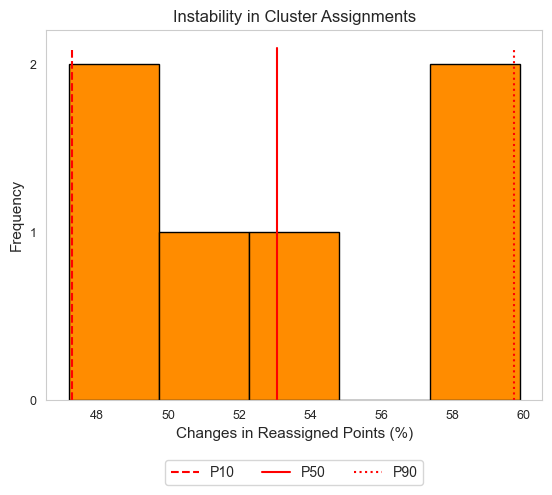

In [9]:
# Visualize changes in cluster assignement over all AE realizations
optimal_bin = knuth_bin_width(change_percentages)
plt.hist(change_percentages, bins=optimal_bin, color='darkorange', edgecolor='black')
histogram_bounds(ax_or_plt=plt, optimal_bin=optimal_bin, values=change_percentages, weights=np.ones(len(change_percentages)), color='red')
plt.xlabel('Changes in Reassigned Points (%)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Instability in Cluster Assignments')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tick_params(axis='both', labelsize=9)
plt.legend(loc='lower center', bbox_to_anchor=(0.50, -0.25), ncol=3)
plt.savefig('Instability in Cluster Assignemnts.tiff', dpi=300, bbox_inches='tight')
plt.show()

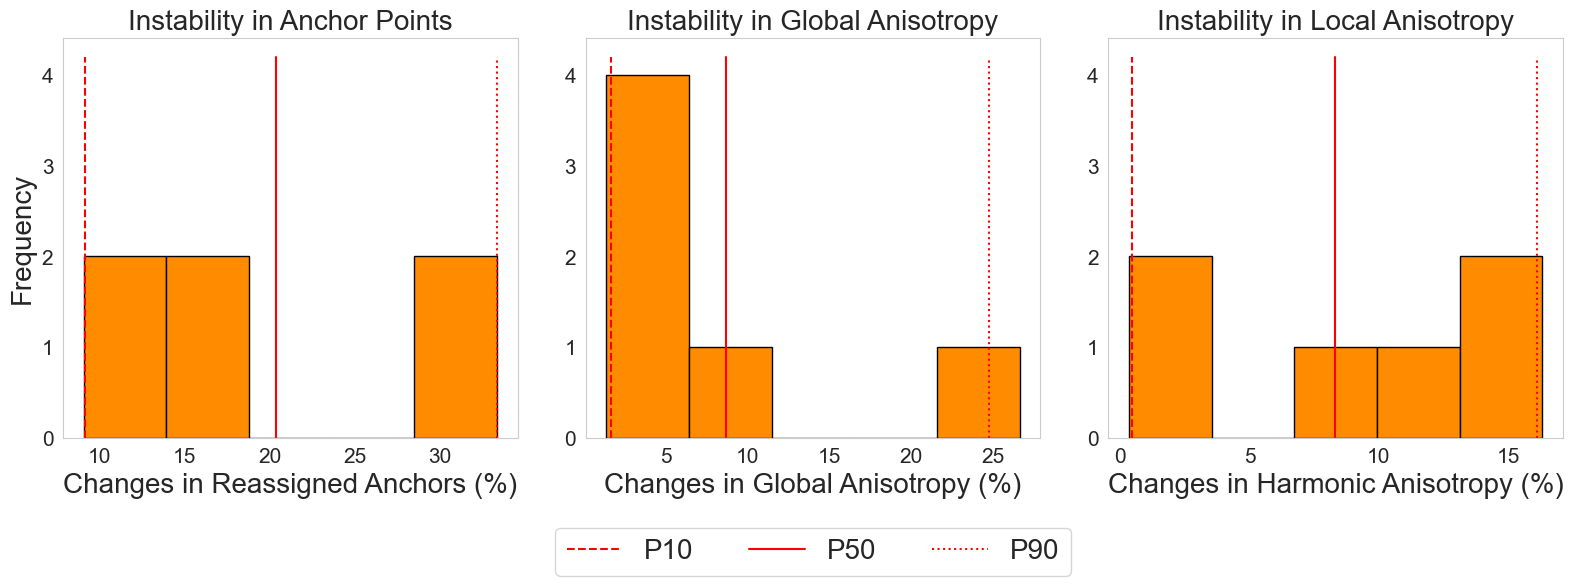

In [10]:
# Find optimal bins for each stats
optimal_bin1 = knuth_bin_width(change_anchors)
optimal_bin2 = knuth_bin_width(change_global_anis)
optimal_bin3 = knuth_bin_width(change_har_anis)

# Compute histogram data
hist_data_1, _ = np.histogram(change_anchors, bins=optimal_bin1)
hist_data_2, _ = np.histogram(change_global_anis, bins=optimal_bin2)
hist_data_3, _ = np.histogram(change_har_anis, bins=optimal_bin3)

# Obtain the maximum frequency from all histogram data since the sample size is same for each metric i.e. 1000 AE realizations
overall_max_freq = max(max(hist_data_1), max(hist_data_2), max(hist_data_3))
overall_max_freq += overall_max_freq * 0.05

# Visualize percentage changes for shape-based statistics
fig, axs = plt.subplots(1, 3, figsize=(10, 4)) #-o #8,4 ?
axs[0].hist(change_anchors, bins=optimal_bin1, color='darkorange', edgecolor='black')
histogram_bounds(ax_or_plt=axs[0], optimal_bin=optimal_bin1, values=change_anchors,weights=np.ones(len(change_anchors)), color='red', max_freq_override=overall_max_freq)
axs[0].set_xlabel('Changes in Reassigned Anchors (%)', fontsize= 20)
axs[0].set_ylabel('Frequency', fontsize= 20)
axs[0].set_title('Instability in Anchor Points', fontsize= 20)
axs[0].tick_params(axis='both', labelsize=15)
axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].hist(change_global_anis, bins=optimal_bin2, color='darkorange', edgecolor='black')
histogram_bounds(ax_or_plt=axs[1], optimal_bin=optimal_bin2, values=change_global_anis,weights=np.ones(len(change_global_anis)),color='red', max_freq_override=overall_max_freq)
axs[1].set_xlabel('Changes in Global Anisotropy (%)', fontsize= 20)
axs[1].set_title('Instability in Global Anisotropy', fontsize= 20)
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[1].tick_params(axis='both', labelsize=15)

axs[2].hist(change_har_anis, bins=optimal_bin3, color='darkorange', edgecolor='black') # based off F1 score computation INSPO!
histogram_bounds(ax_or_plt=axs[2], optimal_bin=optimal_bin, values=change_har_anis,weights=np.ones(len(change_har_anis)),color='red', max_freq_override=overall_max_freq)
axs[2].set_xlabel('Changes in Harmonic Anisotropy (%)', fontsize= 20)
axs[2].set_title('Instability in Local Anisotropy', fontsize= 20)
axs[2].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[2].tick_params(axis='both', labelsize=15)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[:3], labels[:3], loc='lower center', bbox_to_anchor=(0.75, -0.08), ncol=3, fontsize=20)

plt.subplots_adjust(left=0.0, bottom=0.3, right=1.5, top=1.3, wspace=0.15, hspace=0.3)
plt.savefig('Instability in Shape-based Statistics.tiff', dpi=300, bbox_inches='tight')
plt.show()

## Stress and Jaccard Computations

In [11]:
# Stress computation for unique pairs only
with h5py.File(hdf5_file, 'r') as f:
    N = len(f.keys())
    # Initialize matrix
    adjusted_stress_matrix = np.zeros((N, N))

    for i in range(N):
        embedding_i = f[f'embedding_realizations_{i}'][:]
        for j in range(i + 1, N):  # Starting from i + 1 to avoid redundant computations
            embedding_j = f[f'embedding_realizations_{j}'][:]

            # Compute adjusted raw_stress
            adj_stress = adjusted_stress(embedding_i, embedding_j)
            adjusted_stress_matrix[i, j] = adj_stress
            adjusted_stress_matrix[j, i] = adj_stress

# To compare the sets of vertices from the convex hulls across different realizations, let's use set operations.
# The idea is to assess the overlap and differences between the sets of indices for each pair of AE realizations
# and compute the Jaccard similarity.

comparisons = {}
for (i, vertices_i), (j, vertices_j) in combinations(enumerate(convex_hull_vertices), 2):
    set_i, set_j = set(vertices_i.tolist()), set(vertices_j.tolist())
    intersection = set_i.intersection(set_j)
    union = set_i.union(set_j)
    jaccard_similarity = len(intersection) / len(union) if union else 1
    comparisons[(i, j)] = jaccard_similarity

# Compute Jaccard similarity matrix
num_realizations = len(convex_hull_vertices)
similarity_matrix = np.zeros((num_realizations, num_realizations))

for (i, j), similarity in comparisons.items():
    similarity_matrix[i, j] = similarity
    similarity_matrix[j, i] = similarity  # Mirror the similarity as the matrix is symmetric

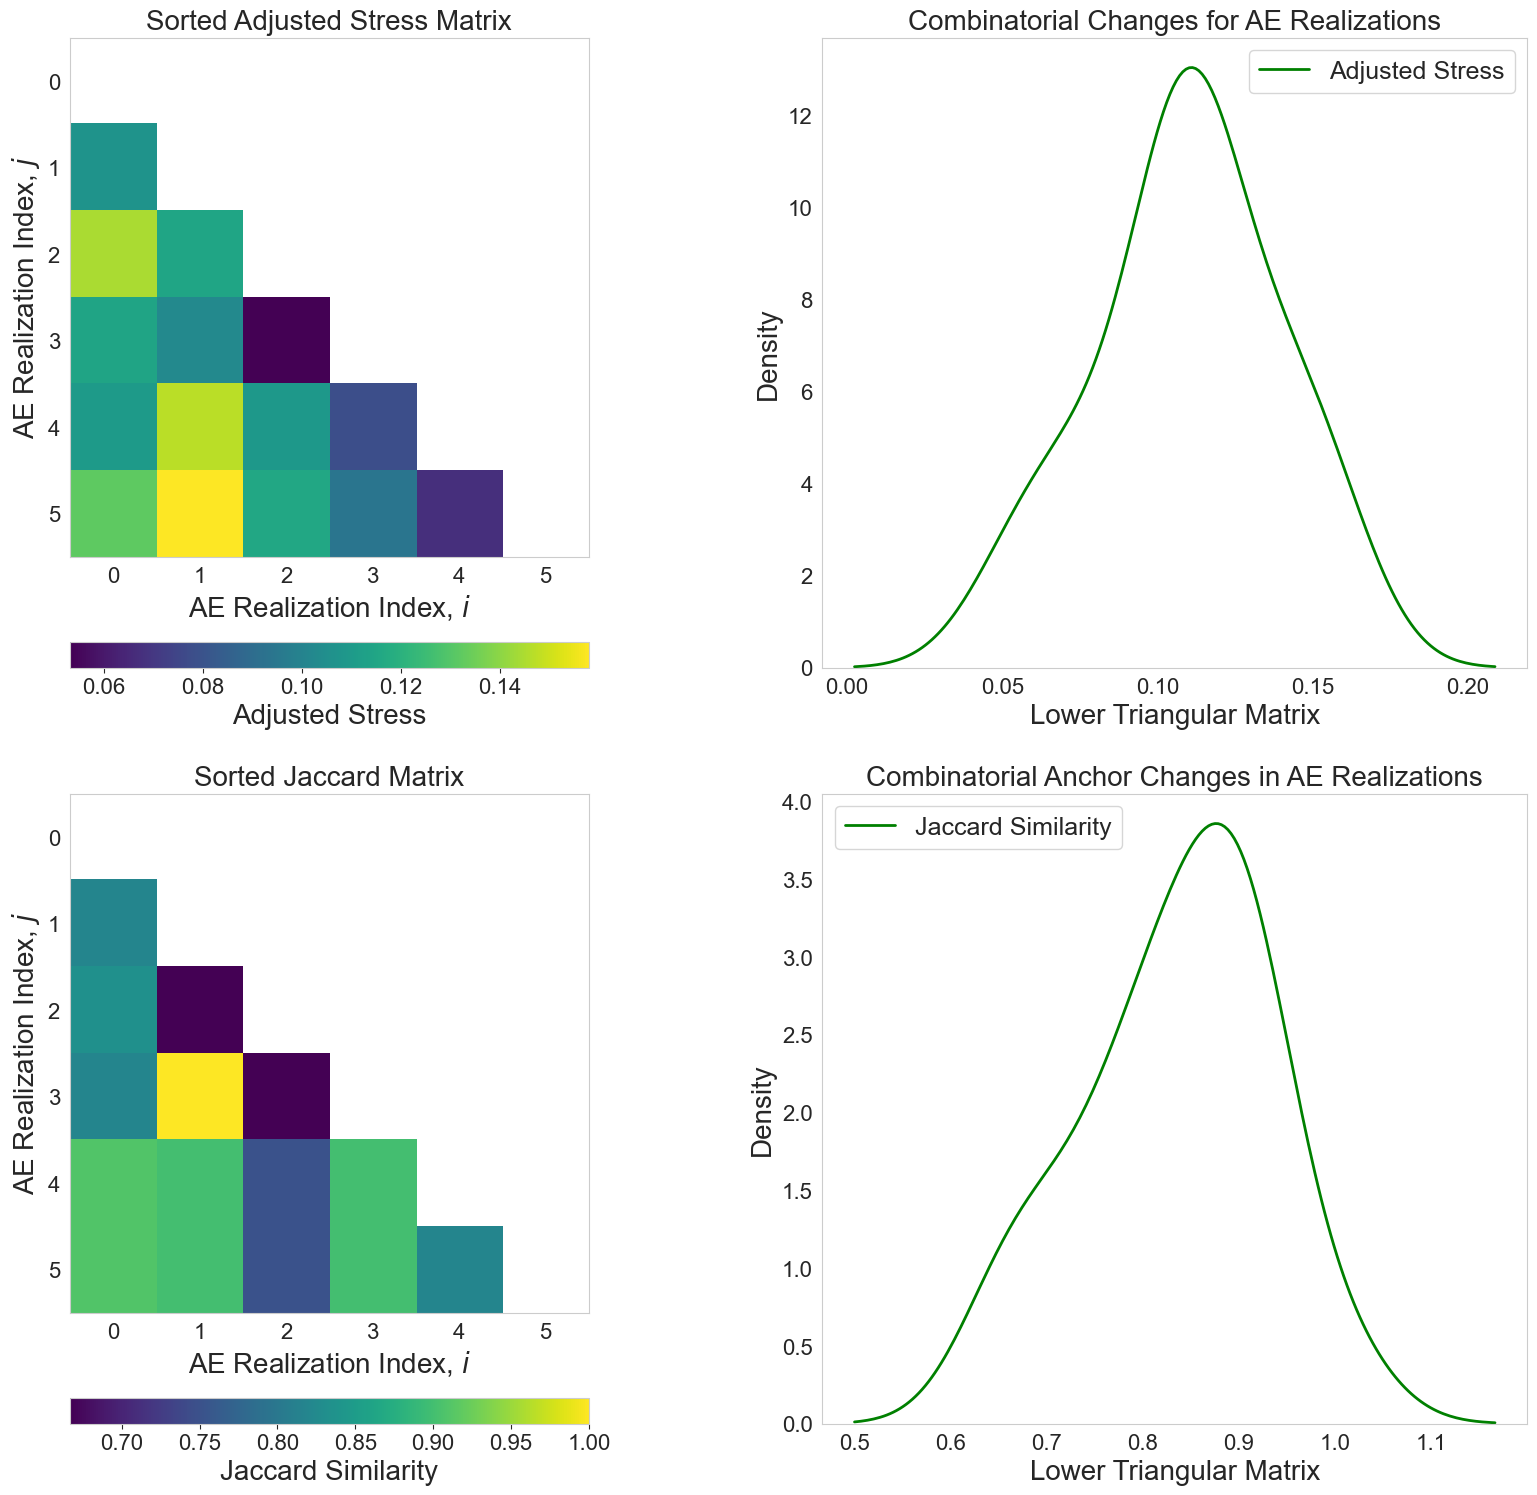

In [12]:
# Compute and Visualize stress measures
ordered_dist_mat1, res_order1, res_linkage1 = compute_serial_matrix(adjusted_stress_matrix,"ward")

# Extract the lower triangular matrix for the sorted stress matrices excluding diagonal and visualize via kde
lower_triangle1 = np.tril(ordered_dist_mat1, k=-1) # Adjusted stress
exclude_diag = lower_triangle1[lower_triangle1 == 0] = np.nan
flatten_data1 = lower_triangle1[lower_triangle1 != 0]

# Compute and Visualize Jaccard similarity measures
ordered_dist_mat2, res_order2, res_linkage2 = compute_serial_matrix(similarity_matrix,"ward")

# Extract the lower triangular matrix for the sorted stress matrices excluding diagonal and visualize via kde
lower_triangle2 = np.tril(ordered_dist_mat2, k=-1) # Modified raw stress
exclude_diag2 = lower_triangle2[lower_triangle2 == 0] = np.nan
flatten_data2 = lower_triangle2[lower_triangle2 != 0]

# Save stress and jaccard values to numpy arrays
# np.save('jaccard_array_corr_0.npy', flatten_data2)
# np.save('jaccard_array_wine.npy', flatten_data2)
np.save('jaccard_array_corr_1.npy', flatten_data2)

# np.save('stress_array_corr_0.npy', flatten_data1)
# np.save('stress_array_wine.npy', flatten_data1)
np.save('stress_array_corr_1.npy', flatten_data1)

fig, axs = plt.subplots(2, 2, figsize=(20, 18)) # orange and purple
# Sorted Adjusted Stress - lower triangle matrix excluding diagonal
im1 = axs[0, 0].imshow(lower_triangle1, cmap="viridis")
axs[0, 0].set_title("Sorted Adjusted Stress Matrix", size=20)
axs[0, 0].set_xlabel("AE Realization Index, $i$", size=20)
axs[0, 0].set_ylabel("AE Realization Index, $j$", size=20)
axs[0, 0].tick_params(axis='both', which='major', labelsize=16)
# Aesthetics
divider = make_axes_locatable(axs[0, 0])
cax1 = divider.append_axes("bottom", size="5%", pad=0.85)
cbar1 = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.25)
cbar1.set_label('Adjusted Stress', size=20)
cbar1.ax.tick_params(labelsize=16)

# KDE of lower triangular matrix of adjusted stress excluding the diagonal
sns.kdeplot(flatten_data1, ax=axs[0, 1], color='green', label='Adjusted Stress', linewidth=2)
axs[0, 1].set_title("Combinatorial Changes for AE Realizations", size=20)
axs[0, 1].set_xlabel('Lower Triangular Matrix', fontsize=20)
axs[0, 1].set_ylabel('Density', fontsize=20)
axs[0, 1].tick_params(labelsize=16)
axs[0, 1].legend(fontsize=18)

# Sorted Adjusted Jaccard - lower triangle matrix excluding diagonal
im1 = axs[1, 0].imshow(lower_triangle2, cmap="viridis")
axs[1, 0].set_title("Sorted Jaccard Matrix", size=20)
axs[1, 0].set_xlabel("AE Realization Index, $i$", size=20)
axs[1, 0].set_ylabel("AE Realization Index, $j$", size=20)
axs[1, 0].tick_params(axis='both', which='major', labelsize=16)
# Aesthetics
divider = make_axes_locatable(axs[1, 0])
cax1 = divider.append_axes("bottom", size="5%", pad=0.85)
cbar1 = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.25)
cbar1.set_label('Jaccard Similarity', size=20)
cbar1.ax.tick_params(labelsize=16)

# KDE of lower triangular matrix of Jaccard excluding the diagonal
sns.kdeplot(flatten_data2, ax=axs[1, 1], bw_method='scott', color='green', label='Jaccard Similarity', linewidth=2)
axs[1, 1].set_title("Combinatorial Anchor Changes in AE Realizations", size=20)
axs[1, 1].set_xlabel('Lower Triangular Matrix', fontsize=20)
axs[1, 1].set_ylabel('Density', fontsize=20)
axs[1, 1].tick_params(labelsize=16)
axs[1, 1].legend(fontsize=18)

# Customization
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.savefig('Combined Stress and Jaccard Analysis.tiff', dpi=300, bbox_inches='tight')
plt.show()

## Analyze Statistics

In [13]:
# Extract local anisotropies
max_length = max(len(arr) for arr in local_anisotropies) # also yields the max number of arrays that the original list is seperated into
element_arrays = [np.array([arr[i] if i < len(arr) else np.nan for arr in local_anisotropies]) for i in range(max_length)]

print(max_length)

1


In [14]:
change_anchors = percentage_change(convex_hull_vertices, data_type='list')

# Compute the percentage changes in Moran's
change_moran = percentage_change(statistics_array[:,0], data_type='numpy')

# Compute the percentage changes in anisotropies found
change_mvee_anis = percentage_change(statistics_array[:,1], data_type='numpy')
change_global_anis = percentage_change(statistics_array[:,2], data_type='numpy')
change_har_anis = percentage_change(statistics_array[:,3], data_type='numpy')

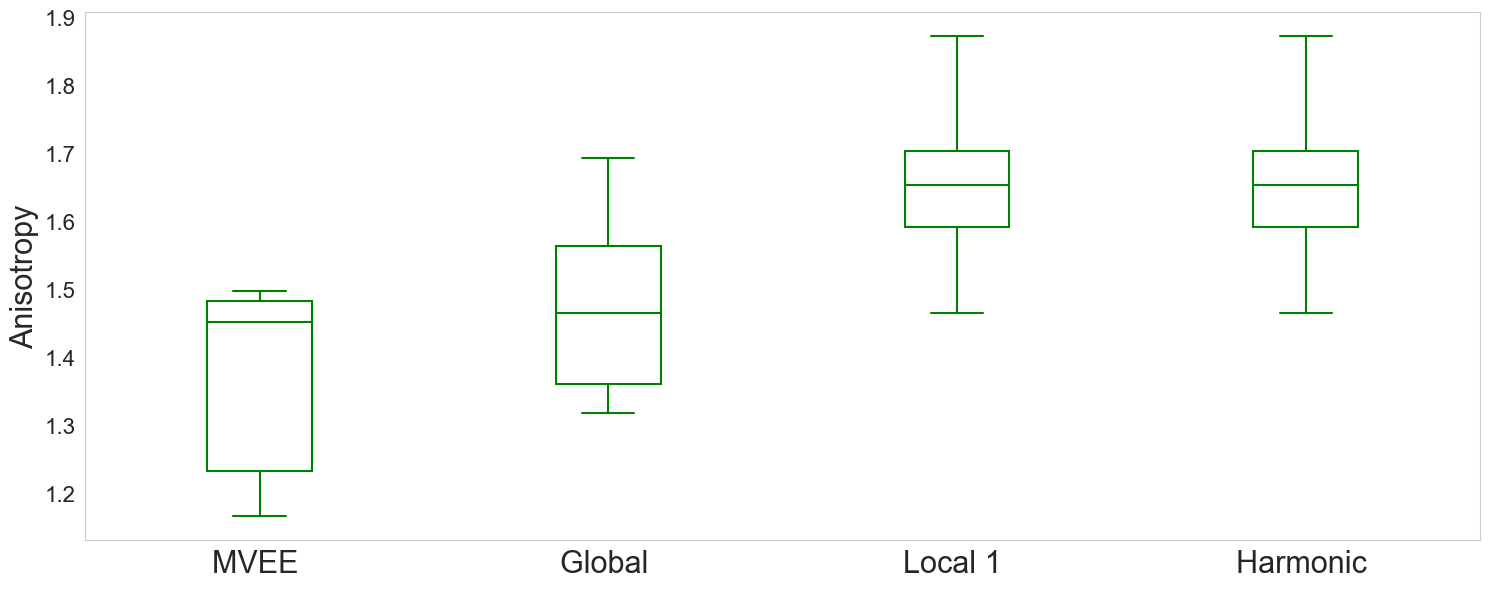

In [15]:
# Visualize Anisotropy alongside types of local that exist too
anisotropy_dict = {
              'MVEE ': statistics_array[:,1],
              'Global ': statistics_array[:,2],
              'Local 1 ': element_arrays[0],
              # 'Local 2 ': element_arrays[1],
              # 'Local 3 ': element_arrays[2],
              'Harmonic ': statistics_array[:,3]
              }

# make_boxplot(dictionary=anisotropy_dict, y_label="Anisotropy", box_width=0.3, c_str='red')
# make_boxplot(dictionary=anisotropy_dict, y_label="Anisotropy", box_width=0.3, c_str='blue')
make_boxplot(dictionary=anisotropy_dict, y_label="Anisotropy", box_width=0.3, c_str='green')


# box_plot(dictionary=anisotropy_dict, var_name='Anisotropies', value_name='Anisotropy', save_title='Anisotropy measures for all AE realizations', xlabel_rot=45)

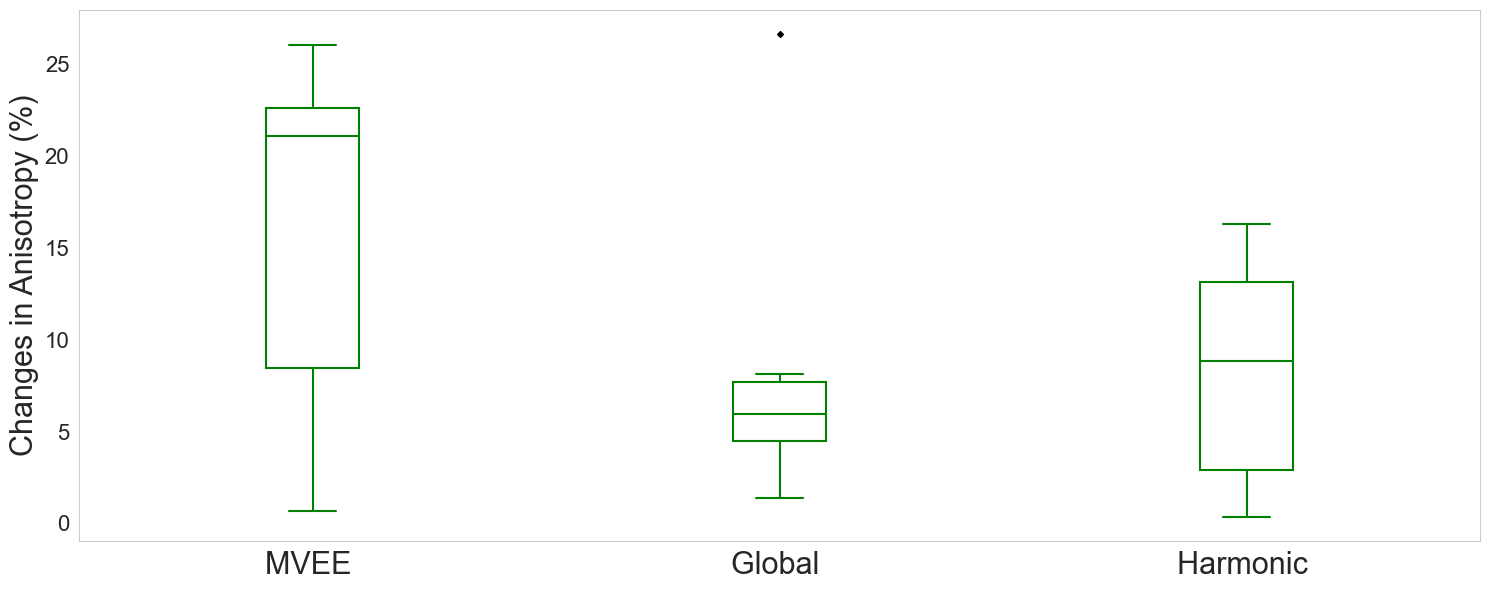

In [16]:
# Visualize major anisotropy stats
change_anisotropy_dict = {
              'MVEE ': np.array(change_mvee_anis),
              'Global ': np.array(change_global_anis),
              'Harmonic ': np.array(change_har_anis)
              }

# make_boxplot(dictionary=change_anisotropy_dict, y_label="Changes in Anisotropy (%)", box_width=0.2, c_str='red')
# make_boxplot(dictionary=change_anisotropy_dict, y_label="Changes in Anisotropy (%)", box_width=0.2, c_str='blue')
make_boxplot(dictionary=change_anisotropy_dict, y_label="Changes in Anisotropy (%)", box_width=0.2, c_str='green')


# box_plot(dictionary=change_anisotropy_dict, var_name='Anisotropies', value_name='Changes in Anisotropy (%)', save_title='Change in Anisotropy measures for all AE realizations')

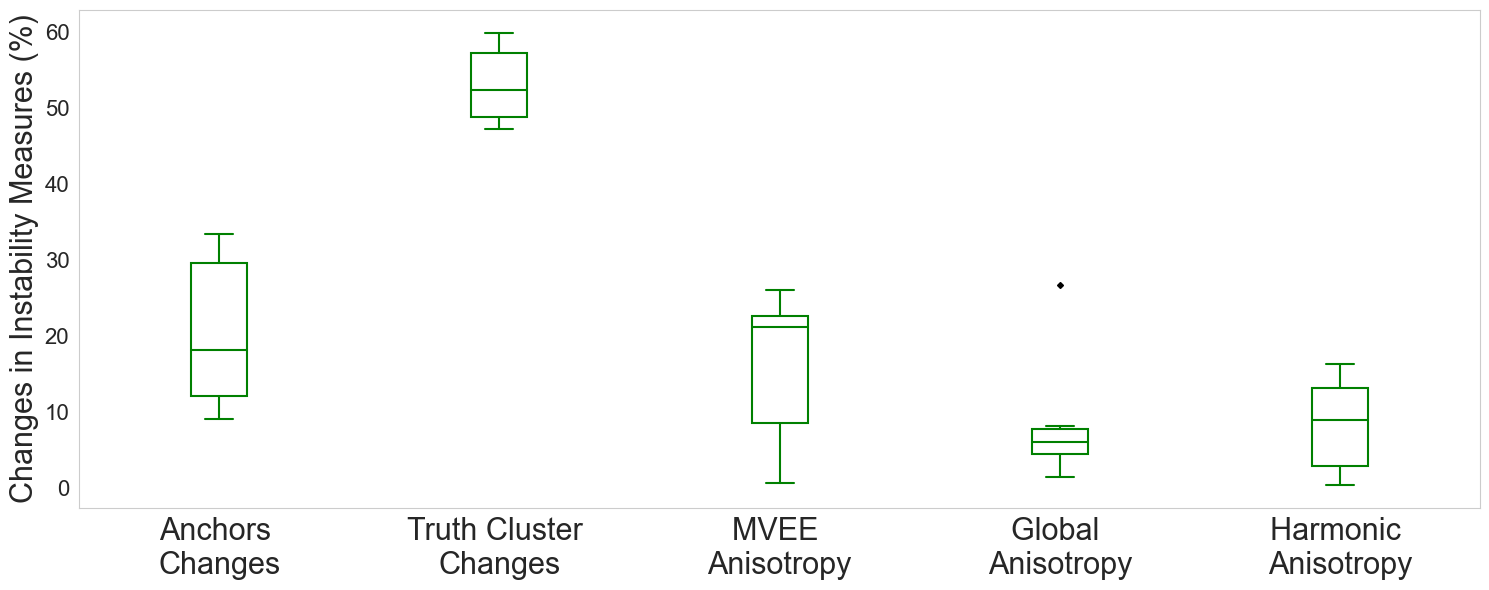

In [17]:
# Visualize changes in instability measures
# instability_measures_corr_0= {
# instability_measures_wine= {
instability_measures_corr_1= {
              'Anchors \nChanges': np.array(change_anchors),
              'Truth Cluster \nChanges': np.array(change_percentages),
              'MVEE \nAnisotropy': np.array(change_mvee_anis),
              'Global \nAnisotropy': np.array(change_global_anis),
              'Harmonic \nAnisotropy': np.array(change_har_anis),
              }

# make_boxplot(dictionary=instability_measures_corr_0, y_label="Changes in Instability Measures (%)", box_width=0.2, c_str='red')
# make_boxplot(dictionary=instability_measures_wine, y_label="Changes in Instability Measures (%)", box_width=0.2, c_str='blue')
make_boxplot(dictionary=instability_measures_corr_1, y_label="Changes in Instability Measures (%)", box_width=0.2, c_str='green')


# box_plot(dictionary=instability_measures_corr_1, var_name='Reassignments', value_name='Changes in Instability Measures (%)', save_title='Change in Instability measures for all AE realizations', box_width=0.6, xlabel_rot=45)

In [18]:
# Save pickled instability measures and other metrics for each case/scenario to file
# pickle_file1 = 'instability_measures_corr_0.pkl'
# with open(pickle_file1, 'wb') as file:
#     pickle.dump(instability_measures_corr_0, file)
#
# pickle_file2 = 'instability_measures_wine.pkl'
# with open(pickle_file2, 'wb') as file:
#     pickle.dump(instability_measures_wine, file)

pickle_file3 = 'instability_measures_corr_1.pkl'
with open(pickle_file3, 'wb') as file:
    pickle.dump(instability_measures_corr_1, file)

## Latent Space Anisotropy Visualizations

For correlation = 0, visualize realization index 199 for bimodal local anisotropy computation

In [21]:
# Extract embedding at idx 199 since it is examplary for the case of multiple local anisotropy that differs from global anisotropy
with h5py.File(hdf5_file, 'r') as f:
    key = f'embedding_realizations_199'
    if key in f:
        example_embedding = f[key][:]

    else:
        print(f"Key '{key}' not found in the HDF5 file.")

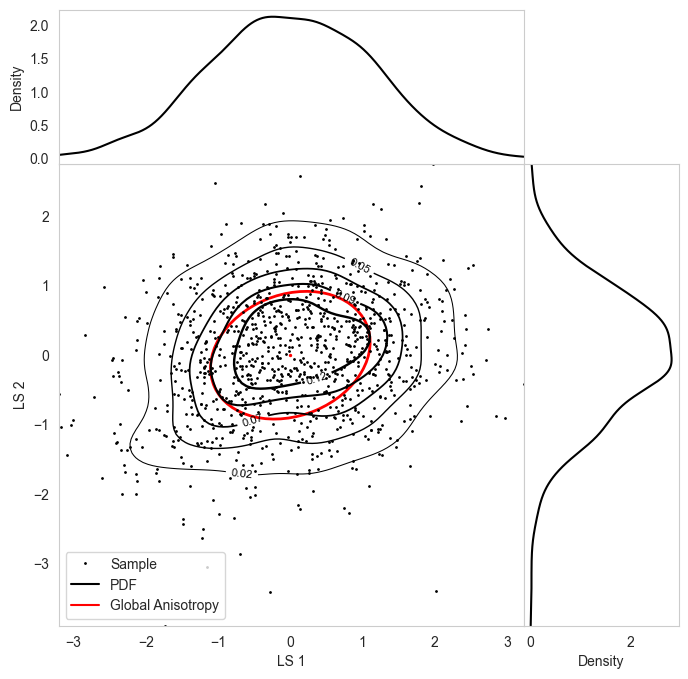

1.3183603888916637


In [23]:
global_anis, local_anis, harmonic_anis = compute_anisotropy(array_2d=example_embedding, type='global', plotter=True)
print(global_anis)

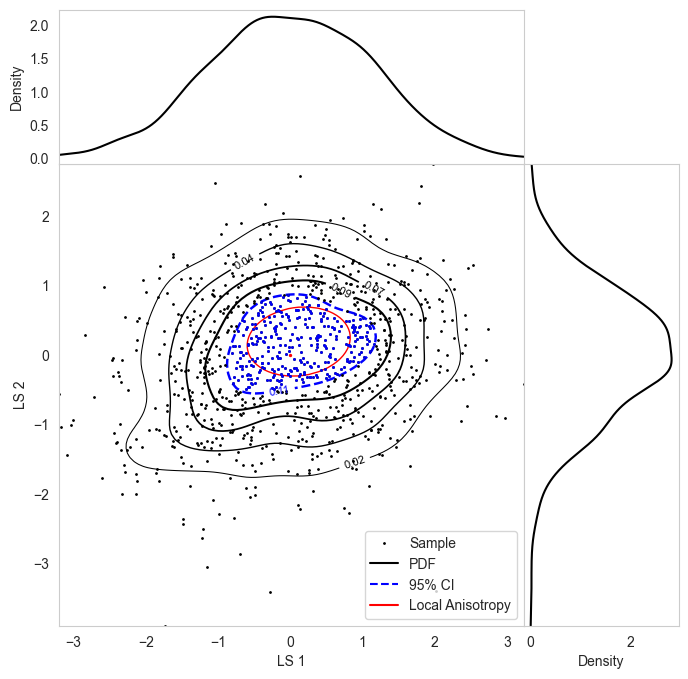

[1.4615050329114334] 1.4615050329114334


In [24]:
global_anis, local_anis, harmonic_anis = compute_anisotropy(array_2d=example_embedding, type='local', plotter=True)
print(local_anis, harmonic_anis)

## Five Point Statistics

In [ ]:
# arr_changes = np.array(change_percentages) # can be any statistics
# sorted_data = np.sort(arr_changes)
#
# # Calculate the 5-point statistic
# minimum = np.min(sorted_data)
# maximum = np.max(sorted_data)
# median = np.median(sorted_data)
# q1 = np.percentile(sorted_data, 25)
# q3 = np.percentile(sorted_data, 75)
# variance = np.var(sorted_data)
#
# # Display the five-number summary
# print("Minimum:", round(minimum, 5))
# print("First Quartile (Q1):", round(q1, 5))
# print("Median (Q2):", round(median, 5))
# print("Third Quartile (Q3):", round(q3, 5))
# print("Maximum:", round(maximum, 5))
# print("Variance:", round(variance, 5))

## Comparative Analyses

In [ ]:
# # Compare KDE over bookends(i.e., correlation 0 and 1) and wine dataset
# Load saved lower triangular matrices for the sorted stress matrices excluding diagonal and visualize via kde
# jaccard_corr_0 = np.load('jaccard_array_corr_0.npy')
# jaccard_wine = np.load('jaccard_array_wine.npy')
# jaccard_corr_1 = np.load('jaccard_array_corr_1.npy')
#
# stress_corr_0 = np.load('stress_array_corr_0.npy')
# stress_wine = np.load('stress_array_wine.npy')
# stress_corr_1 = np.load('stress_array_corr_1.npy')

# Curate jaccard arrays for all scenarios/case studies
# jaccard_dictionary = {
#     'No Correlation': jaccard_corr_0,
#     'Wine Dataset': jaccard_wine,
#     'Perfect Correlation': jaccard_corr_1
# }

# stress_dictionary = {
#     'No Correlation': stress_corr_0,
#     'Wine Dataset': stress_wine,
#     'Perfect Correlation': stress_corr_1
# }

# compare_kde(jaccard_dictionary, xlabel='Lower Triangular Jaccard Similarity Matrix')
# compare_kde(stress_dictionary, xlabel='Lower Triangular Adjusted Stress Matrix')

In [ ]:
# pickle_file1 = 'instability_measures_corr_0.pkl'
# with open(pickle_file1, 'rb') as file:
#     instability_measures_corr_0 = pickle.load(file)

# pickle_file2 = 'instability_measures_wine.pkl'
# with open(pickle_file2, 'rb') as file:
#     instability_measures_wine = pickle.load(file)

# pickle_file3 = 'instability_measures_corr_1.pkl'
# with open(pickle_file3, 'rb') as file:
#     instability_measures_corr_1 = pickle.load(file)

# all_dicts = [instability_measures_corr_0, instability_measures_wine, instability_measures_corr_1]
# compare_boxplot(dictionary_list=all_dicts, y_label='Changes in Instability Measures (%)')